### This code is the implementation of RankNet using TensorFlow 2 custom training loop

[For details please check this blog post](https://louiskitlunglaw.medium.com/ranknet-factorised-ranknet-lambdarank-explained-implementation-via-tensorflow-2-part-ii-f28bd5a8a6d5)

keywords: learning to rank | tensorflow | keras | custom training loop | ranknet | lambdaRank

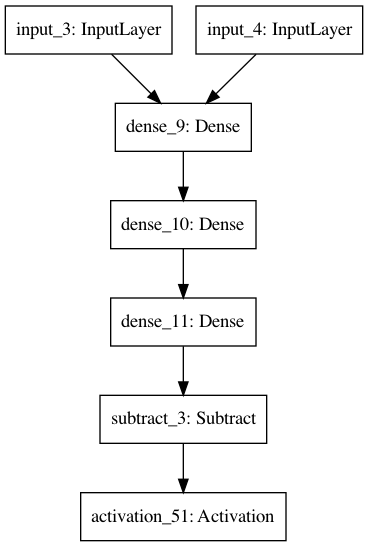

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# generate data
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_id = np.array(pair_id)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

In [2]:
# compute gradient and do backpropagation
def apply_gradient(optimizer, loss_object, model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss_value = loss_object(y, y_pred)
    
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return y_pred, loss_value

In [4]:
# train for one epoch
def train_data_for_one_epoch_efficient(optimizer, loss_object, model, steps_total=None, apply_gradient=None):
    losses = []
    
    pb_i = Progbar(steps_total)
    for (i,j) in pair_id_train:
        _xi = doc_features[[i]]
        _xj = doc_features[[j]]
        _pij = [[0.5]]
        if doc_scores[i] < doc_scores[j]:
            _pij = [[0]]
        elif doc_scores[i] > doc_scores[j]:
            _pij = [[1]]
        y_pred, loss_value = apply_gradient(optimizer, loss_object, model, [_xi, _xj], _pij)
        losses.append(loss_value)

        pb_i.add(1)
    return losses

# train for one epoch
def train_data_for_one_epoch(optimizer, loss_object, model, steps_total=None, apply_gradient=None):
    losses = []
    
    pb_i = Progbar(steps_total)
    for step, (_xi, _xj, _pij) in enumerate(train):
        y_pred, loss_value = apply_gradient(optimizer, loss_object, model, [_xi, _xj], _pij)
        losses.append(loss_value)

        pb_i.add(1)
    return losses

In [10]:
# compute loss on val set
def compute_val_loss_efficient(loss_object, model):
    losses = []
    _xi = doc_features[pair_id_test[:,0]]
    _xj = doc_features[pair_id_test[:,1]]
    scorei = doc_scores[pair_id_test[:,0]]
    scorej = doc_scores[pair_id_test[:,1]]
    _pij = (scorei > scorej).astype(float)
    _pij[scorei==scorej] = 0.5
    _pij = _pij.reshape(-1,1)
    
    pij_pred = model([_xi, _xj])
    loss_value = loss_object(y_true=_pij, y_pred=pij_pred)
    losses.append(loss_value)
    
    return losses

# compute loss on val set
def compute_val_loss(loss_object, model):
    losses = []
    for _xi, _xj, _pij in test:
        pij_pred = model([_xi, _xj])
        loss_value = loss_object(y_true=_pij, y_pred=pij_pred)
        losses.append(loss_value)
    return losses

Epoch 1/50
2713/2713 [==============================] - 2s 467us/step
Train loss: 0.6821  Validation Loss: 0.6631
Epoch 2/50
2713/2713 [==============================] - 1s 477us/step
Train loss: 0.6576  Validation Loss: 0.6407
Epoch 3/50
2713/2713 [==============================] - 1s 477us/step
Train loss: 0.6341  Validation Loss: 0.6227
Epoch 4/50
2713/2713 [==============================] - 1s 462us/step
Train loss: 0.6148  Validation Loss: 0.6097
Epoch 5/50
2713/2713 [==============================] - 1s 480us/step
Train loss: 0.6003  Validation Loss: 0.5998
Epoch 6/50
2713/2713 [==============================] - 1s 484us/step
Train loss: 0.5893  Validation Loss: 0.5930
Epoch 7/50
2713/2713 [==============================] - 1s 497us/step
Train loss: 0.5820  Validation Loss: 0.5880
Epoch 8/50
2713/2713 [==============================] - 1s 503us/step
Train loss: 0.5751  Validation Loss: 0.5834
Epoch 9/50
2713/2713 [==============================] - 1s 548us/step
Train loss: 0.5678

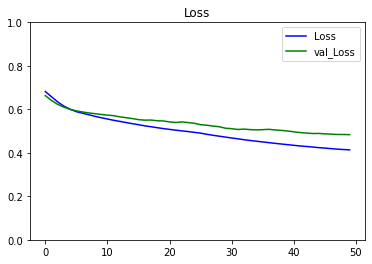

In [6]:
# ready dataset
batch_size = 1
train = tf.data.Dataset.from_tensor_slices((xi_train, xj_train, pij_train)).batch(batch_size)
test = tf.data.Dataset.from_tensor_slices((xi_test, xj_test, pij_test)).batch(len(xi_test))
steps_total = np.ceil(len(xi_train) // batch_size)

# init loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()


# start training
ranknet = RankNet()

epochs = 50
loss_train_history = []
loss_val_history = []
apply_gradient_graph = tf.function(apply_gradient)

for epoch in range(epochs):
    print('Epoch %d/%d'%(epoch+1, epochs))
    losses_train = train_data_for_one_epoch(optimizer, loss_object, ranknet, steps_total, apply_gradient_graph)
    loss_train_history.append(np.mean(losses_train))
    loss_val_history.append(np.mean(compute_val_loss(loss_object, ranknet)))
    print('Train loss: %.4f  Validation Loss: %.4f' % (float(loss_train_history[-1]), float(loss_val_history[-1])))

# plot loss history
plot_metrics(loss_train_history, loss_val_history, "Loss", "Loss", ylim=1.0)

Epoch 1/50
1706/1706 [==============================] - 1s 569us/step
Train loss: 0.6828  Validation Loss: 0.6797
Epoch 2/50
1706/1706 [==============================] - 1s 404us/step
Train loss: 0.6584  Validation Loss: 0.6701
Epoch 3/50
1706/1706 [==============================] - 1s 425us/step
Train loss: 0.6440  Validation Loss: 0.6632
Epoch 4/50
1706/1706 [==============================] - 1s 411us/step
Train loss: 0.6333  Validation Loss: 0.6557
Epoch 5/50
1706/1706 [==============================] - 1s 447us/step
Train loss: 0.6193  Validation Loss: 0.6472
Epoch 6/50
1706/1706 [==============================] - 1s 482us/step
Train loss: 0.6052  Validation Loss: 0.6342
Epoch 7/50
1706/1706 [==============================] - 1s 484us/step
Train loss: 0.5893  Validation Loss: 0.6221
Epoch 8/50
1706/1706 [==============================] - 1s 445us/step
Train loss: 0.5771  Validation Loss: 0.6092
Epoch 9/50
1706/1706 [==============================] - 1s 422us/step
Train loss: 0.5665

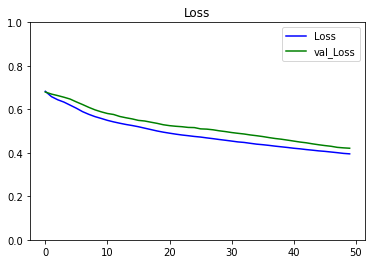

In [11]:
# ready dataset
batch_size = 1
train = tf.data.Dataset.from_tensor_slices((xi_train, xj_train, pij_train)).batch(batch_size)
test = tf.data.Dataset.from_tensor_slices((xi_test, xj_test, pij_test)).batch(len(xi_test))
steps_total = np.ceil(len(xi_train) // batch_size)

# init loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()


# start training
ranknet = RankNet()

epochs = 50
loss_train_history = []
loss_val_history = []
apply_gradient_graph = tf.function(apply_gradient)

for epoch in range(epochs):
    print('Epoch %d/%d'%(epoch+1, epochs))
    losses_train = train_data_for_one_epoch_efficient(optimizer, loss_object, ranknet, steps_total, apply_gradient_graph)
    loss_train_history.append(np.mean(losses_train))
    loss_val_history.append(np.mean(compute_val_loss_efficient(loss_object, ranknet)))
    print('Train loss: %.4f  Validation Loss: %.4f' % (float(loss_train_history[-1]), float(loss_val_history[-1])))

# plot loss history
plot_metrics(loss_train_history, loss_val_history, "Loss", "Loss", ylim=1.0)